In [1]:
import pandas as pd
from tqdm import tqdm
from pyarrow import csv
import pyarrow as pa

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from catboost import CatBoostClassifier
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd 
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve

import pandas as pd
from tqdm import tqdm
from pyarrow import csv
import pyarrow as pa

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from catboost import CatBoostClassifier
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
def get_data(filename, scaler=None, useScaler=False):
    df = pd.read_csv(filename)
    Y = df.Label
    df = df.drop(['Unnamed: 0', 'Label'], axis=1)

    df['Attack'] = df['Attack'].astype("string")

    X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.3,stratify=df.Attack, random_state=42)
    del df
    del Y

    attack_train = X_train['Attack']
    X_train = X_train.drop('Attack', axis=1)
    attack_test = X_test['Attack']
    X_test = X_test.drop('Attack', axis=1)

    X_train = X_train.drop(['SimillarHTTP'], axis=1)
    X_train[X_train['Flow Bytes/s'] == np.inf] = 0
    X_train[X_train[' Flow Packets/s'] == np.inf] = 0

    X_test = X_test.drop(['SimillarHTTP'], axis=1)
    X_test[X_test['Flow Bytes/s'] == np.inf] = 0
    X_test[X_test[' Flow Packets/s'] == np.inf] = 0

    
    if useScaler:
        X_train = scaler.transform(X_train)
    else:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, attack_train, attack_test, scaler

In [3]:
X_train, X_test, y_train, y_test, attack_train, attack_test, scaler = get_data('triple.csv')

/tmp/ipykernel_164171/3331398274.py:2: DtypeWarning: Columns (62,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [4]:
class Data(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
class modelDNN(nn.Module):
    def __init__(self):
        super(modelDNN, self).__init__()        
        self.layer_1 = nn.Linear(111, 4096) 
        self.layer_2 = nn.Linear(4096, 2048)
        self.layer_3 = nn.Linear(2048, 64) 
        self.layer_4 = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(4096)
        self.batchnorm2 = nn.BatchNorm1d(2048)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_4(x)
        
        return x
    
class tabularCNN(nn.Module):
    def __init__(self):
        super(tabularCNN, self).__init__()        
        self.layer_1 = nn.Linear(111, 1024) 
        self.layer_2 = nn.Linear(1024, 4096)
        self.layer_3 = nn.Linear(32*36, 1024) 
        self.layer_4 = nn.Linear(1024, 64) 
        self.layer_5 = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(4096)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_1 = nn.Conv2d(1, 32, 3)
        self.conv_2 = nn.Conv2d(32, 32, 3)
        self.conv_3 = nn.Conv2d(32, 32, 3)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        #print(x.shape)
        x = x.reshape(len(x), 1, 64, 64)
        x = self.pool(self.relu(self.conv_1(x)))
        x = self.pool(self.relu(self.conv_2(x)))
        x = self.pool(self.relu(self.conv_3(x)))
        #print(x.shape)
        x = x.reshape(len(x), 32*36)
        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.layer_5(x)
        
        return x
    
def binary_acc(y_pred, y_test):

    y_pred_tag = torch.round(torch.sigmoid(y_pred))


    correct_results_sum = (y_pred_tag.detach().cpu().numpy().reshape(-1) == y_test.detach().cpu().numpy().reshape(-1)).sum()

    acc = correct_results_sum/y_test.shape[0]

    acc *= 100
    
    return acc

In [5]:
device = torch.device("cuda:0")

In [6]:
y_test

526880     0
267191     0
2427419    1
2137147    1
849088     0
          ..
1265954    0
1586351    0
2326272    1
1379098    1
207158     0
Name: Label, Length: 978719, dtype: int64

In [10]:
y_train.shape

(2283675,)

In [11]:
train_data = Data(torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy()))
test_data = Data(torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy()))

In [12]:
scaler

MinMaxScaler()

In [13]:
save(scaler, "scalerCNN_N.pckle")

'scalerCNN_N.pckle)' was not found in history, as a file, url, nor in the user namespace.


In [14]:
model = tabularCNN().to(device)

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [17]:
train_loader = DataLoader(dataset=train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=512, shuffle=True)
epochs = 1

In [18]:
y_train

1200616    0
2809390    1
1684472    0
2720134    1
3118546    1
          ..
125996     0
2136059    1
2993373    1
1001700    0
1512220    0
Name: Label, Length: 2283675, dtype: int64

In [21]:
save(y_train, "Y_CNN.pckl")

In [19]:
import pickle

def save(data, filename):
    file = open(filename, 'wb')
    pickle.dump(data, file)
    file.close()

In [20]:
for e in range(1):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    acc = 0
    del X_batch, y_batch
    model.eval()

    acc= 0
    total=0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)
        total += 1

        p_acc = binary_acc(y_pred, y_batch)
        acc += p_acc
    
    acc /= total
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Train Acc: {epoch_acc/len(train_loader):.3f} | Test acc: {acc}')
    print("-----------------------------------------------------------------------------------------------------------------------\n")

Epoch 000: | Loss: 0.01475 | Train Acc: 99.499 | Test acc: 99.60324548867966
-----------------------------------------------------------------------------------------------------------------------



In [22]:
X_train.shape

(2283675, 111)

In [24]:
X_test.shape

(978719, 111)

In [28]:
X = np.append(X_train, X_test, axis=0)
del X_train, X_test
X.shape

NameError: name 'X_train' is not defined

In [31]:
Y = np.append(y_train, y_test, axis=0)
del y_train, y_test
Y.shape

(3262394,)

In [33]:
save(Y, "Y_CNN.pckl")

In [ ]:
tn, fp, fn, tp = 0, 0, 0, 0
for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(X_batch)
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    tn_, fp_, fn_, tp_ = confusion_matrix(y_batch.cpu().detach().numpy(), y_pred_tag.cpu().detach().numpy()).ravel()
    tn += tn_
    fp += fp_
    fn += fn_
    tp += tp_

In [ ]:
tn, fp, fn, tp

(1363831, 5932, 2428, 911484)

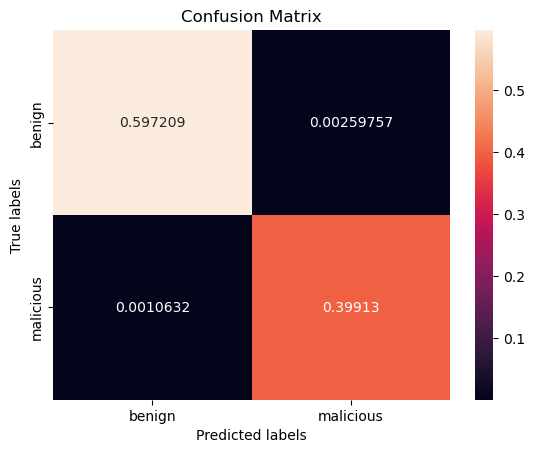

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt     

full = tn + fp + fn + tp

ax= plt.subplot()
sns.heatmap([[tn/ full, fp / full],[fn/full, tp/full]], annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['benign', 'malicious']); ax.yaxis.set_ticklabels(['benign', 'malicious']);

In [16]:
torch.save(model, "TCNN.torch")

In [ ]:
y_batch.shape[0] / X_test.shape[0]

In [ ]:
p_acc * (y_batch.shape[0] / X_test.shape[0])

In [ ]:
binary_acc(y_pred, y_batch)

In [ ]:
del X_batch, y_batch
model.eval()

i = 0
acc= 0
for X_batch, y_batch in train_loader:
    i+=1
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    optimizer.zero_grad()

    y_pred = model(X_batch)
        
    p_acc = binary_acc_verbal(y_pred, y_batch)
    acc += p_acc * (y_batch.shape[0] / X_test.shape[0])
    print("===current acc ===")
    print(p_acc)
    print("-------------\n")
    
    if i >= 2:
        break

In [ ]:
def binary_acc_verbal(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    print(y_pred_tag.shape)
    correct_results_sum = (y_pred_tag.detach().cpu().numpy().reshape(-1) == y_test.detach().cpu().numpy().reshape(-1)).sum()
    print(correct_results_sum)
    print(y_test.shape[0])
    acc = correct_results_sum/y_test.shape[0]
    print(acc)
    acc *= 100
    print("---------------------------------")
    
    return acc


In [ ]:
y_pred.detach().cpu().numpy().reshape(-1)

In [60]:
y_batch.detach().cpu().numpy().reshape(-1) == y_pred.detach().cpu().numpy().reshape(-1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [34]:
#model = torch.load("TCNN.torch")
model.eval()

tabularCNN(
  (layer_1): Linear(in_features=111, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=4096, bias=True)
  (layer_3): Linear(in_features=1152, out_features=1024, bias=True)
  (layer_4): Linear(in_features=1024, out_features=64, bias=True)
  (layer_5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

In [35]:
model.layer_5 = nn.Sequential()

In [36]:
model

tabularCNN(
  (layer_1): Linear(in_features=111, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=4096, bias=True)
  (layer_3): Linear(in_features=1152, out_features=1024, bias=True)
  (layer_4): Linear(in_features=1024, out_features=64, bias=True)
  (layer_5): Sequential()
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_s

In [37]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [38]:
data = TestData(torch.tensor(X, dtype=torch.float32))

In [39]:
loader = DataLoader(dataset=data, batch_size=512, shuffle=False)

In [40]:
model.cpu()

f = True
dataset = None
i = 0
for X_batch in loader:
    i+=1
    if i % 100 == 0:
        print(i)
    if f:
        pd.DataFrame(model(X_batch).detach().numpy()).to_csv("post_cnn.csv")
        f = False
    else:
        pd.DataFrame(model(X_batch).detach().numpy()).to_csv("post_cnn.csv", mode='a', header=False)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300


In [58]:
len(loader)

4461

In [47]:
model.layer_4

Linear(in_features=1024, out_features=1, bias=True)

In [57]:
model(X_batch).detach().numpy()

array([[ 4.3536409e-13,  2.8846152e-15, -1.3971698e-11, ...,
         5.1700841e-03, -6.3485328e-12, -1.1142309e-23],
       [ 4.3536409e-13,  2.8846152e-15, -1.3971698e-11, ...,
         7.4318410e-03, -6.3485328e-12, -1.1142309e-23],
       [ 4.3536409e-13,  2.8846152e-15, -1.3971698e-11, ...,
         3.4897977e-03, -6.3485328e-12, -1.1142309e-23],
       ...,
       [ 4.3536409e-13,  2.8846152e-15, -1.3971698e-11, ...,
        -6.5774848e-03, -6.3485328e-12, -1.1142309e-23],
       [ 4.3536409e-13,  2.8846152e-15, -1.3971698e-11, ...,
         6.3968156e-03, -6.3485328e-12, -1.1142309e-23],
       [ 4.3536409e-13,  2.8846152e-15, -1.3971698e-11, ...,
        -6.0826213e-05, -6.3485328e-12, -1.1142309e-23]], dtype=float32)

In [4]:
from datret.datret import DatRetClassifier

2023-06-03 13:44:28.436566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 13:44:31.676821: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-03 13:44:31.677043: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-03 13:44:31.677053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [5]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.1767659 , 0.13260478,
        0.5       ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.22095738, 0.22100797,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.41981902, 0.22100797,
        0.5       ]])

In [6]:
y_train

1200616    0
2809390    1
1684472    0
2720134    1
3118546    1
          ..
125996     0
2136059    1
2993373    1
1001700    0
1512220    0
Name: Label, Length: 2283675, dtype: int64

In [7]:
DR = DatRetClassifier(epoch=1)
DR.fit(X_train, y_train)

2023-06-03 13:44:34.557099: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1013951700 exceeds 10% of free system memory.


228367/228367 [==============================] - 465s 2ms/step - loss: 0.0294 - lr: 0.0010


In [8]:
accuracy_score(y_test, DR.predict(X_test))

30585/30585 [==============================] - 32s 1ms/step


0.9945581929031724

In [1]:
tn, fp, fn, tp = confusion_matrix(y_test, DR.predict(X_test)).ravel()

NameError: name 'confusion_matrix' is not defined

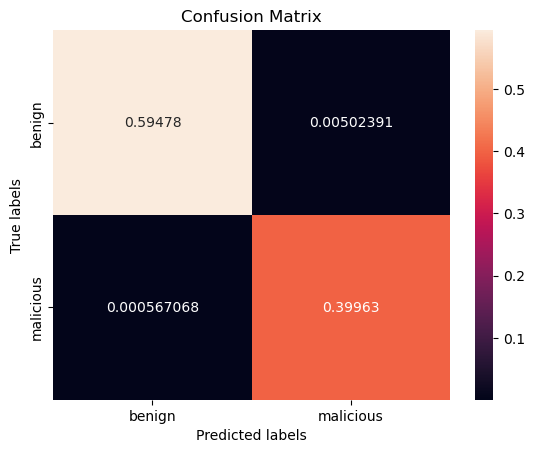

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt     

full = tn + fp + fn + tp

ax= plt.subplot()
sns.heatmap([[tn/ full, fp / full],[fn/full, tp/full]], annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['benign', 'malicious']); ax.yaxis.set_ticklabels(['benign', 'malicious']);

In [19]:
X_train, y_train

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.5       ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ],
        [0.        , 0.        , 0.        , ..., 0.1767659 , 0.13260478,
         0.5       ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ],
        [0.        , 0.        , 0.        , ..., 0.22095738, 0.22100797,
         0.5       ],
        [0.        , 0.        , 0.        , ..., 0.41981902, 0.22100797,
         0.5       ]]),
 1200616    0
 2809390    1
 1684472    0
 2720134    1
 3118546    1
           ..
 125996     0
 2136059    1
 2993373    1
 1001700    0
 1512220    0
 Name: Label, Length: 2283675, dtype: int64)

In [39]:
tp, fp, fn, tn = 0.5948, 0.00072, 0.00493, 0.399471

In [40]:
precision = tp / (tp + fp)

In [41]:
recall = tp / (tp + fn)

In [42]:
precision, recall

(0.9987909725953787, 0.9917796341687093)

In [13]:
tp, fp, fn, tn = 598187, 1036, 2337, 144607

In [14]:
full = tp + fp + fn + tn

In [15]:
(full-(fp + fn))/full

0.9954795642262388

In [19]:
fp

1036

In [20]:
tp

598187

In [21]:
tp / (tp + fp)

0.998271094400582